<a href="https://colab.research.google.com/github/prajwalpai/Upgrad-Assignments/blob/main/SO_Assignment-complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow EDA on cloud Assignment

## Import libs

In [5]:
!pip3 install pymysql
!pip3 install sqlalchemy
!pip3 install mlxtend

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules 
import pymysql
from sqlalchemy import create_engine
import warnings
import datetime
import numpy as np
warnings.filterwarnings('ignore')

## Read Data from AWS S3

In [4]:
qns = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Questions.csv", encoding = "latin1")
ans = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Answers.csv", encoding = "latin1")
tags = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv", encoding = "latin1")
users = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Users.csv" , encoding = "latin1")

## Check Basic Info of data

 

### Check Shape

In [7]:
qns.shape

(1264216, 7)

In [8]:
qns.sample()

Id  ...                                               Body
334041  12007100  ...  <p>How can I implement something like the foll...

[1 rows x 7 columns]

In [9]:
ans.shape

(2014516, 6)

In [10]:
ans.sample()

Id  ...                                               Body
665468  11872053  ...  <p>Basically just ripping off rdelmar's commen...

[1 rows x 6 columns]

In [11]:
tags.shape

(3750994, 2)

In [12]:
tags.sample()

Id          Tag
219878  3361490  codeigniter

In [13]:
users.shape

(1990480, 9)

### Check Sample 

In [14]:
users.sample()

Unnamed: 0    id  display_name  ... up_votes down_votes  views
180326      180326  2029  Oppositional  ...      355          7    811

[1 rows x 9 columns]

## Cleanup Data


### Remove Null

#### Remove null OwnerUserId in qns

In [15]:
qns = qns[~qns['OwnerUserId'].isnull()]

In [16]:
qns.isnull().sum()

Id                    0
OwnerUserId           0
CreationDate          0
ClosedDate      1194522
Score                 0
Title                 0
Body                  0
dtype: int64

#### Remove null OwnerUserId in ans

In [17]:
ans = ans[~ans['OwnerUserId'].isnull()]

In [18]:
ans.isnull().sum()

Id              0
OwnerUserId     0
CreationDate    0
ParentId        0
Score           0
Body            0
dtype: int64

#### Remove null Tags in tags

In [19]:
tags = tags[~tags['Tag'].isnull()]

In [20]:
tags.isnull().sum()

Id     0
Tag    0
dtype: int64

In [21]:
users.isnull().sum()

Unnamed: 0            0
id                    0
display_name        136
creation_date         0
last_access_date      0
reputation            0
up_votes              0
down_votes            0
views                 0
dtype: int64

#### Remove null display_name in users

In [22]:
users = users[~users['display_name'].isnull()]

In [23]:
users['id'].value_counts()

22656      3270
1144035    3009
29407      2144
548225     1924
115145     1813
           ... 
5588787       1
4138147       1
1417000       1
1427235       1
4098          1
Name: id, Length: 465436, dtype: int64

### Remove unnecessary Data

#### Remove "Unnamed: 0" column from users

In [24]:
users.drop('Unnamed: 0', axis=1, inplace= True)

#### Remove the duplicate rows from users

In [25]:
users.drop_duplicates(inplace = True)

In [26]:
users.isnull().sum()

id                  0
display_name        0
creation_date       0
last_access_date    0
reputation          0
up_votes            0
down_votes          0
views               0
dtype: int64

In [27]:
users

id      display_name  ... down_votes views
0             26             Shawn  ...         67  3547
27          1109              Theo  ...        136  6905
85        364174             stats  ...          1    60
87            61           Bernard  ...        219  1731
97         20709       Black Horus  ...          2    96
...          ...               ...  ...        ...   ...
1990475  4228492  Michael Spranger  ...          2    17
1990476  6820506           Manuela  ...          0    50
1990477  4464432            YTorii  ...          1    13
1990478  4605946     space_voyager  ...          1   191
1990479  6107989         Nicky HFE  ...          0    30

[465436 rows x 8 columns]

#### Remove the duplicate rows from Qns ( Same Questions)

In [28]:
qns.drop_duplicates(inplace = True)

### Standardise Numbers

In [29]:
qns.head()

Id  ...                                               Body
0   80  ...  <p>I've written a database generation script i...
1   90  ...  <p>Are there any really good tutorials explain...
2  120  ...  <p>Has anyone got experience creating <strong>...
3  180  ...  <p>This is something I've pseudo-solved many t...
4  260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

#### Making OwnerUserId an integer

In [30]:
qns['OwnerUserId'] = qns['OwnerUserId'].astype(int)

In [31]:
ans['OwnerUserId'] = ans['OwnerUserId'].astype(int)

In [32]:
qns.head()

Id  ...                                               Body
0   80  ...  <p>I've written a database generation script i...
1   90  ...  <p>Are there any really good tutorials explain...
2  120  ...  <p>Has anyone got experience creating <strong>...
3  180  ...  <p>This is something I've pseudo-solved many t...
4  260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

In [33]:
ans.head()

Id  OwnerUserId  ... Score                                               Body
0   92           61  ...    13  <p><a href="http://svnbook.red-bean.com/">Vers...
1  124           26  ...    12  <p>I wound up using this. It is a kind of a ha...
2  199           50  ...     1  <p>I've read somewhere the human eye can't dis...
3  269           91  ...     4  <p>Yes, I thought about that, but I soon figur...
4  307           49  ...    28  <p><a href="http://www.codeproject.com/Article...

[5 rows x 6 columns]

In [34]:
qns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249762 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Id            1249762 non-null  int64 
 1   OwnerUserId   1249762 non-null  int64 
 2   CreationDate  1249762 non-null  object
 3   ClosedDate    55240 non-null    object
 4   Score         1249762 non-null  int64 
 5   Title         1249762 non-null  object
 6   Body          1249762 non-null  object
dtypes: int64(3), object(4)
memory usage: 76.3+ MB


In [35]:
tags.shape

(3749881, 2)

#### Change the Dates Columns type to DateType.

In [36]:
qns['CreationDate'] = pd.to_datetime(qns['CreationDate'])
ans['CreationDate'] = pd.to_datetime(ans['CreationDate'])

## Handling outliers 

### Outliers in Score in Questions/qns

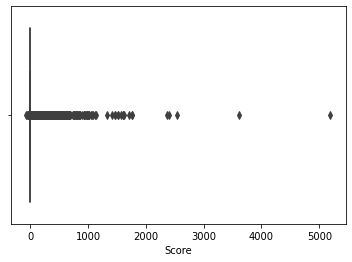

In [37]:
sns.boxplot(qns.Score)

In [38]:
qns = qns[qns.Score < 1200]

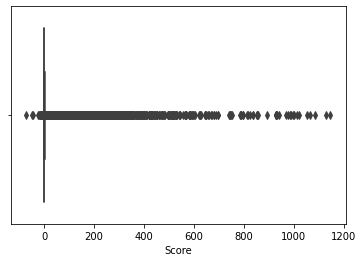

In [39]:
sns.boxplot(qns.Score)

In [40]:
qns.Score.describe()

count    1.249744e+06
mean     1.741049e+00
std      1.070463e+01
min     -7.300000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.147000e+03
Name: Score, dtype: float64

### Outliers in Score in Answers/ans

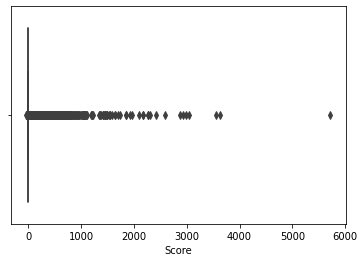

In [41]:
sns.boxplot(ans.Score)

In [42]:
ans = ans[ans.Score < 1100]

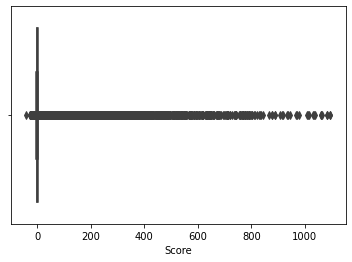

In [43]:
sns.boxplot(ans.Score)

In [44]:
ans.Score.describe()

count    2.001268e+06
mean     2.434043e+00
std      1.221149e+01
min     -4.200000e+01
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.095000e+03
Name: Score, dtype: float64

### Outliers in reputation in Users/users

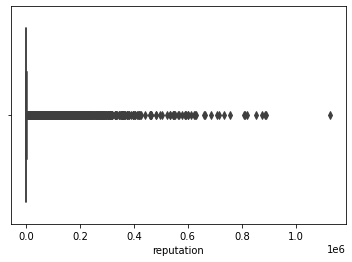

In [45]:
sns.boxplot(users.reputation)

In [46]:
users = users[users.reputation < 600000]

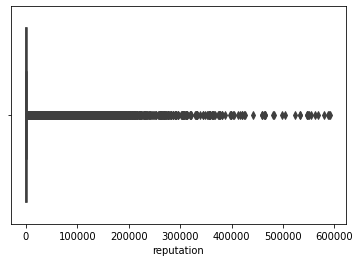

In [47]:
sns.boxplot(users.reputation)

In [48]:
users

id      display_name  ... down_votes views
0             26             Shawn  ...         67  3547
27          1109              Theo  ...        136  6905
85        364174             stats  ...          1    60
87            61           Bernard  ...        219  1731
97         20709       Black Horus  ...          2    96
...          ...               ...  ...        ...   ...
1990475  4228492  Michael Spranger  ...          2    17
1990476  6820506           Manuela  ...          0    50
1990477  4464432            YTorii  ...          1    13
1990478  4605946     space_voyager  ...          1   191
1990479  6107989         Nicky HFE  ...          0    30

[465415 rows x 8 columns]

## Prepping Join/Merge 


In [49]:
qns.head()

Id  ...                                               Body
0   80  ...  <p>I've written a database generation script i...
1   90  ...  <p>Are there any really good tutorials explain...
2  120  ...  <p>Has anyone got experience creating <strong>...
3  180  ...  <p>This is something I've pseudo-solved many t...
4  260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

In [50]:
qns.rename(columns={'Id':'Q_Id', 'OwnerUserId':'Q_OwnerUserId', 'CreationDate':'Q_CreationDate','ClosedDate':'Q_ClosedDate' }, inplace=True)
qns.rename(columns={'Score':'Q_Score', 'Title':'Q_Title', 'Body':'Q_Body' }, inplace=True)

### Renaming Questions columns with Q identifier

In [51]:
qns.head()

Q_Id  ...                                             Q_Body
0    80  ...  <p>I've written a database generation script i...
1    90  ...  <p>Are there any really good tutorials explain...
2   120  ...  <p>Has anyone got experience creating <strong>...
3   180  ...  <p>This is something I've pseudo-solved many t...
4   260  ...  <p>I have a little game written in C#. It uses...

[5 rows x 7 columns]

In [52]:
ans.head()

Id  OwnerUserId  ... Score                                               Body
0   92           61  ...    13  <p><a href="http://svnbook.red-bean.com/">Vers...
1  124           26  ...    12  <p>I wound up using this. It is a kind of a ha...
2  199           50  ...     1  <p>I've read somewhere the human eye can't dis...
3  269           91  ...     4  <p>Yes, I thought about that, but I soon figur...
4  307           49  ...    28  <p><a href="http://www.codeproject.com/Article...

[5 rows x 6 columns]

###  Renaming Answers columns with A identifier

In [53]:
ans.rename(columns={'Id':'A_Id', 'OwnerUserId':'A_OwnerUserId', 'CreationDate':'A_CreationDate' }, inplace=True)
ans.rename(columns={'ParentId':'Q_Id','Score':'A_Score', 'Body':'A_Body' }, inplace=True)

In [54]:
ans.sample()

A_Id  ...                                             A_Body
1294479  24617680  ...  <p>try </p>\n\n<pre><code>nx.is_connected(G)\n...

[1 rows x 6 columns]

In [55]:
qns.sample()

Q_Id  ...                                             Q_Body
748069  25364930  ...  <p>I have a Tour Search application where user...

[1 rows x 7 columns]

### Cosolidating Tags as CSV values grouped by Question ID 

**Breaking up the below commented line to make sure processor is NOT taxed**

Had initiatlly tested with tags.head(5000) and worked well but running on entire dataframe execution almost made jupyter unresponsive.

In [56]:
#tags.groupby(['Id'])['Tag'].apply(lambda Tag: ''.join(Tag.to_string(index=False))).str.replace('(\\n)', ',').reset_index()

In [57]:
tags2 = tags.groupby(['Id'])['Tag']

In [58]:
tags3 = tags2.apply(lambda Tag: ''.join(Tag.to_string(index=False)))

In [59]:
tags3.str.replace('(\\n)', ',').reset_index()

Id                                                Tag
0              80               flex, actionscript-3,            air
1              90                     svn,           tortoisesvn,...
2             120                              sql, asp.net, sitemap
3             180           algorithm, language-agnostic,        ...
4             260                      c#,                  .net,...
...           ...                                                ...
1264209  40143210                                     php, .htaccess
1264210  40143300                                    google-bigquery
1264211  40143340                            android, android-studio
1264212  40143360                             javascript,     vue.js
1264213  40143380                                  npm, mocha, babel

[1264214 rows x 2 columns]

In [60]:
tags=tags3.str.replace('(\\n)', ',').reset_index()

In [61]:
tags

Id                                                Tag
0              80               flex, actionscript-3,            air
1              90                     svn,           tortoisesvn,...
2             120                              sql, asp.net, sitemap
3             180           algorithm, language-agnostic,        ...
4             260                      c#,                  .net,...
...           ...                                                ...
1264209  40143210                                     php, .htaccess
1264210  40143300                                    google-bigquery
1264211  40143340                            android, android-studio
1264212  40143360                             javascript,     vue.js
1264213  40143380                                  npm, mocha, babel

[1264214 rows x 2 columns]

In [62]:
tags.rename(columns={'Id':'Q_Id'}, inplace= True)

In [63]:
tags

Q_Id                                                Tag
0              80               flex, actionscript-3,            air
1              90                     svn,           tortoisesvn,...
2             120                              sql, asp.net, sitemap
3             180           algorithm, language-agnostic,        ...
4             260                      c#,                  .net,...
...           ...                                                ...
1264209  40143210                                     php, .htaccess
1264210  40143300                                    google-bigquery
1264211  40143340                            android, android-studio
1264212  40143360                             javascript,     vue.js
1264213  40143380                                  npm, mocha, babel

[1264214 rows x 2 columns]

In [64]:
users

id      display_name  ... down_votes views
0             26             Shawn  ...         67  3547
27          1109              Theo  ...        136  6905
85        364174             stats  ...          1    60
87            61           Bernard  ...        219  1731
97         20709       Black Horus  ...          2    96
...          ...               ...  ...        ...   ...
1990475  4228492  Michael Spranger  ...          2    17
1990476  6820506           Manuela  ...          0    50
1990477  4464432            YTorii  ...          1    13
1990478  4605946     space_voyager  ...          1   191
1990479  6107989         Nicky HFE  ...          0    30

[465415 rows x 8 columns]

In [65]:
ans.sample()

A_Id  ...                                             A_Body
531587  9364799  ...  <p>Your program violates the One Definition Ru...

[1 rows x 6 columns]

In [66]:
qns.sample()

Q_Id  ...                                             Q_Body
274341  10081070  ...  <p>I need to group numbers that are in numeric...

[1 rows x 7 columns]

In [67]:
tags.sample()

Q_Id                                                Tag
806220  27188200               php, zend-framework2,    view-hel...

In [68]:
users.sample()

id display_name  ... down_votes views
128744  805659     japreiss  ...         23   497

[1 rows x 8 columns]

## Merging Questions, Answers and Tags to get a consolidated DataFrame

In [69]:
qna = pd.merge(qns,ans,how='inner', on='Q_Id')

In [70]:
final_df = pd.merge(qna,tags,how='inner', on='Q_Id')

In [71]:
final_df.sample()

Q_Id  ...          Tag
1020526  18032710  ...    css, html

[1 rows x 13 columns]

In [72]:
users.sample()

id display_name  ... down_votes views
726390  98313        LukeN  ...          7   119

[1 rows x 8 columns]

In [73]:
tags1 = tags.head(5000)

## Filtering the DataFrame to select only DataScience Tagges Queries/Answers

ds_tags = Data Science Tags provided in the Assignment Objectives

In [74]:
ds_tags=['python', 'r', 'matlab', 'sas', 'excel', 'sql']

In [75]:
final_df = final_df[final_df.Tag.astype(str).str.contains(pat="python|matlab|sas|excel|sql|r,")]

In [76]:
final_df = final_df.reset_index(drop=True)

In [77]:
final_df.sample()

Q_Id  ...                                  Tag
181474  17905350  ...            ipython, ipython-notebook

[1 rows x 13 columns]

In [78]:
users.sample()

id  display_name  ... down_votes views
1905673  5757288  Ihor Vahanov  ...          0     0

[1 rows x 8 columns]

## Droping off unnessary columns

In [79]:
Cleaned_up_df = final_df[['Q_Id','Q_CreationDate','A_CreationDate','A_Id', 'A_OwnerUserId','A_Score','Tag']]

In [80]:
Cleaned_up_df

Q_Id  ...                                                Tag
0            120  ...                              sql, asp.net, sitemap
1            580  ...           sql-server,    sql-server-2005,      ...
2            580  ...           sql-server,    sql-server-2005,      ...
3            580  ...           sql-server,    sql-server-2005,      ...
4            580  ...           sql-server,    sql-server-2005,      ...
...          ...  ...                                                ...
388241  40142380  ...                             python,   unix,  split
388242  40142550  ...                        mysql,       sql, left-join
388243  40142860  ...                               excel, excel-formula
388244  40143190  ...                       python,      bash, multiline
388245  40143190  ...                       python,      bash, multiline

[388246 rows x 7 columns]

## Draw Maps for each of the Data Science Tag

In [81]:
map_dict={}
for tag in ds_tags:
  print(f"Processing {tag}")
  map_dict[tag] = Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)]['A_OwnerUserId'].value_counts()[:10].sort_values()

Processing python
Processing r
Processing matlab
Processing sas
Processing excel
Processing sql


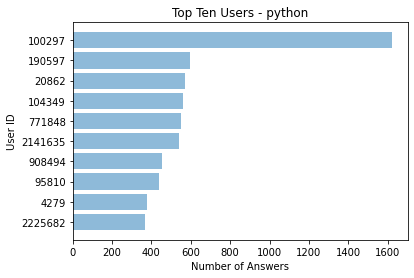

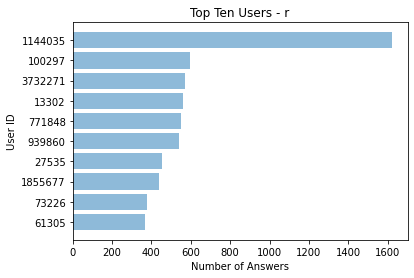

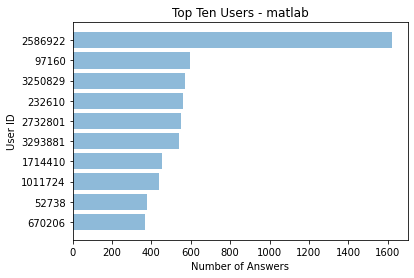

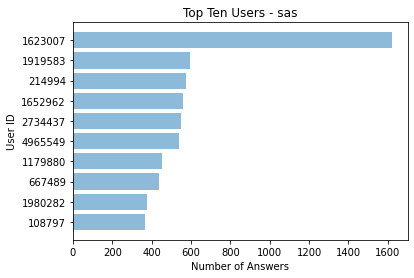

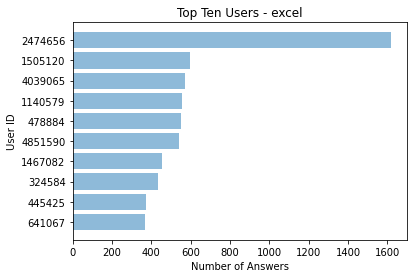

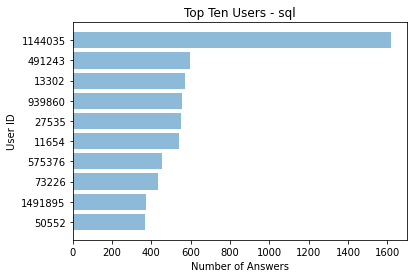

In [82]:
for tag in ds_tags:
  useridlist = [str(int) for int in map_dict[tag].index]
  plt.barh(useridlist, list(map_dict['python']), align='center', alpha=0.5)
  plt.ylabel("User ID") 
  plt.xlabel("Number of Answers") 
  plt.title('Top Ten Users - '+tag)
  plt.show()

In [83]:
Cleaned_up_df['Response_time'] = Cleaned_up_df['A_CreationDate'] - Cleaned_up_df['Q_CreationDate']

In [84]:
Cleaned_up_df

Q_Id  ...    Response_time
0            120  ... 53 days 06:51:03
1            580  ...  0 days 00:09:05
2            580  ...  0 days 00:20:10
3            580  ...  0 days 00:51:04
4            580  ...  0 days 01:06:04
...          ...  ...              ...
388241  40142380  ...  0 days 01:01:25
388242  40142550  ...  0 days 00:09:07
388243  40142860  ...  0 days 00:13:43
388244  40143190  ...  0 days 00:02:16
388245  40143190  ...  0 days 00:06:34

[388246 rows x 8 columns]

## Find ID of Top 5 users who have answered most questions 

## Find 50perentile and 75perentile Response time for each of Data Science Tag

In [85]:
top5_dict={}
for tag in ds_tags:
  print(f"Processing {tag}")
  top5_dict[tag] = {}
  userid_list =  Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)]['A_OwnerUserId'].value_counts()[:5]
  useridlist_str = [str(int) for int in userid_list.index]
  top5_dict[tag]['useridlst'] = ','.join(useridlist_str)
  top5_dict[tag]['resp-50'] = Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)].groupby(['Q_Id']).min()['Response_time'].describe()[5]
  top5_dict[tag]['resp-75'] = Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)].groupby(['Q_Id']).min()['Response_time'].describe()[6]


Processing python
Processing r
Processing matlab
Processing sas
Processing excel
Processing sql


In [86]:
top5_dict

{'excel': {'resp-50': Timedelta('0 days 00:37:56.500000'),
  'resp-75': Timedelta('0 days 03:05:28.250000'),
  'useridlst': '2474656,1505120,4039065,1140579,478884'},
 'matlab': {'resp-50': Timedelta('0 days 00:37:42.500000'),
  'resp-75': Timedelta('0 days 03:11:01'),
  'useridlst': '2586922,97160,232610,3250829,2732801'},
 'python': {'resp-50': Timedelta('0 days 00:20:11'),
  'resp-75': Timedelta('0 days 02:24:26'),
  'useridlst': '100297,190597,20862,104349,771848'},
 'r': {'resp-50': Timedelta('0 days 00:27:04'),
  'resp-75': Timedelta('0 days 03:47:01.750000'),
  'useridlst': '1144035,100297,3732271,13302,771848'},
 'sas': {'resp-50': Timedelta('0 days 01:49:45'),
  'resp-75': Timedelta('0 days 15:24:12'),
  'useridlst': '1623007,1919583,214994,2734437,1652962'},
 'sql': {'resp-50': Timedelta('0 days 00:13:34'),
  'resp-75': Timedelta('0 days 01:03:58.750000'),
  'useridlst': '1144035,491243,13302,939860,27535'}}

In [87]:
rowlist=[]
col1=[]
col2=[]
col3=[]

for tag in ds_tags:
  rowlist.append(tag)
  col1.append(top5_dict[tag]['useridlst'])
  col2.append(top5_dict[tag]['resp-50'])
  col3.append(top5_dict[tag]['resp-75'])



In [88]:
rowlist

['python', 'r', 'matlab', 'sas', 'excel', 'sql']

In [89]:
col2

[Timedelta('0 days 00:20:11'),
 Timedelta('0 days 00:27:04'),
 Timedelta('0 days 00:37:42.500000'),
 Timedelta('0 days 01:49:45'),
 Timedelta('0 days 00:37:56.500000'),
 Timedelta('0 days 00:13:34')]

In [90]:

Final_Results = pd.DataFrame(
    {'Top 5 Users who can answer': col1,
     '50%-Response-time (mins)': col2,
     '75%-Response-time (mins)': col3
    },index=rowlist)

In [91]:
Final_Results

Top 5 Users who can answer  ... 75%-Response-time (mins)
python       100297,190597,20862,104349,771848  ...          0 days 02:24:26
r          1144035,100297,3732271,13302,771848  ...   0 days 03:47:01.750000
matlab    2586922,97160,232610,3250829,2732801  ...          0 days 03:11:01
sas     1623007,1919583,214994,2734437,1652962  ...          0 days 15:24:12
excel   2474656,1505120,4039065,1140579,478884  ...   0 days 03:05:28.250000
sql          1144035,491243,13302,939860,27535  ...   0 days 01:03:58.750000

[6 rows x 3 columns]

In [92]:
Final_Results['50%-Response-time (mins)'] = Final_Results['50%-Response-time (mins)'].astype('timedelta64[m]')
Final_Results['75%-Response-time (mins)'] = Final_Results['75%-Response-time (mins)'].astype('timedelta64[m]')


In [94]:
Final_Results

Top 5 Users who can answer  ...  75%-Response-time (mins)
python       100297,190597,20862,104349,771848  ...                     144.0
r          1144035,100297,3732271,13302,771848  ...                     227.0
matlab    2586922,97160,232610,3250829,2732801  ...                     191.0
sas     1623007,1919583,214994,2734437,1652962  ...                     924.0
excel   2474656,1505120,4039065,1140579,478884  ...                     185.0
sql          1144035,491243,13302,939860,27535  ...                      63.0

[6 rows x 3 columns]

# Objective 3 ; Predict use of better Tags ; Using Apriori on Tags! 


Reading Data of Tags from scratch

In [95]:
data = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv", encoding = "latin1")

In [96]:
data['Tag'] = data['Tag'].astype('str')

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [98]:
data['Tag'].unique


<bound method Series.unique of 0                    flex
1          actionscript-3
2                     air
3                     svn
4             tortoisesvn
                ...      
3750989        javascript
3750990            vue.js
3750991               npm
3750992             mocha
3750993             babel
Name: Tag, Length: 3750994, dtype: object>

**There is 3750994 unique tags, so Filtering only the Data Science relevan tags**

---



---



##Filtering Data Science tagged Data

In [99]:
data_filtered = data[data['Tag'].str.contains(pat="python|matlab|sas|excel|sql|r,")]

In [100]:
len(data_filtered['Tag'].unique())

652

##Prepping the Data for Apriori

In [101]:
data_for_apriori = data_filtered.groupby(['Id','Tag'])['Tag'].count().unstack().reset_index().fillna(0).set_index('Id')

## Applying the apriori module
Since this is just 1/3 of the objective , Using the module instead of implemting from scratch

In [102]:
frq_items = apriori(data_for_apriori, min_support = 0.005, use_colnames = True)

In [103]:
frq_items

support                            itemsets
0   0.055648                             (excel)
1   0.027883                         (excel-vba)
2   0.007186                       (linq-to-sql)
3   0.034807                            (matlab)
4   0.227566                             (mysql)
5   0.009973                            (mysqli)
6   0.007508                             (plsql)
7   0.031838                        (postgresql)
8   0.346199                            (python)
9   0.030884                        (python-2.7)
10  0.022626                        (python-3.x)
11  0.005075                              (sass)
12  0.191757                               (sql)
13  0.097320                        (sql-server)
14  0.009775                   (sql-server-2005)
15  0.026259                   (sql-server-2008)
16  0.005257                (sql-server-2008-r2)
17  0.005991                   (sql-server-2012)
18  0.028049                            (sqlite)
19  0.006334                           (sqlite3)
20  0.022283                              (tsql)
21  0.018510                  (excel, excel-vba)
22  0.045091                        (sql, mysql)
23  0.008457                   (sql, postgresql)
24  0.019989                (python-2.7, python)
25  0.015461                (python-3.x, python)
26  0.042883                   (sql-server, sql)
27  0.012465              (sql, sql-server-2008)
28  0.011774                         (tsql, sql)
29  0.011152       (sql-server, sql-server-2008)
30  0.014100                  (sql-server, tsql)
31  0.006608  (sql-server, sql, sql-server-2008)
32  0.008114             (sql-server, tsql, sql)

In [209]:
so_rules = association_rules(frq_items, metric ="lift", min_threshold = .5) 
so_rules =so_rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
so_rules

antecedents  ... conviction
28                    (tsql, sql)  ...   2.903643
8                    (python-3.x)  ...   2.064585
1                     (excel-vba)  ...   2.809298
6                    (python-2.7)  ...   1.853349
19                         (tsql)  ...   2.457985
21  (sql-server, sql-server-2008)  ...   1.983437
26             (sql-server, tsql)  ...   1.903749
22         (sql, sql-server-2008)  ...   1.920982
14                         (tsql)  ...   1.713756
13              (sql-server-2008)  ...   1.538614
10                   (sql-server)  ...   1.444940
17              (sql-server-2008)  ...   1.569043
30                         (tsql)  ...   1.505179
0                         (excel)  ...   1.456632
5                    (postgresql)  ...   1.100567
25              (sql-server-2008)  ...   1.278940
2                           (sql)  ...   1.009911
11                          (sql)  ...   1.162696
3                         (mysql)  ...   1.007966
27              (sql-server, sql)  ...   1.205871
20              (sql-server, sql)  ...   1.151111
18                   (sql-server)  ...   1.143367
16                   (sql-server)  ...   1.099766
29                   (sql-server)  ...   1.078108
23                   (sql-server)  ...   1.059469
12                          (sql)  ...   1.041439
15                          (sql)  ...   1.041676
7                        (python)  ...   1.028501
9                        (python)  ...   1.023063
4                           (sql)  ...   1.012828
31                          (sql)  ...   1.029459
24                          (sql)  ...   1.024138

[32 rows x 9 columns]

# Trending Topics over last 6 months

Most Recent Date

In [105]:
qns['Q_CreationDate'].describe()['last']

Timestamp('2016-10-19 23:57:31+0000', tz='UTC')

In [106]:
three_month_qns=np.array((qns[qns['Q_CreationDate'] > pd.Timestamp('2016-7-19 ', tz='UTC')]['Q_Id']))

In [107]:
three_month_qns

array([38447640, 38447690, 38447740, ..., 40143340, 40143360, 40143380])

In [108]:
tags_orig = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv", encoding = "latin1")

Filter only Tags from Last 3 Months

In [109]:
tags_orig = tags_orig[tags_orig['Id'].isin(three_month_qns)]

In [111]:
topten_trends = tags_orig.set_index('Id')['Tag'].value_counts().nlargest(10)

In [112]:
topten_trends.values / topten_trends.values.sum()

array([0.17950343, 0.13064395, 0.11592979, 0.10736412, 0.10656623,
       0.09757815, 0.07741951, 0.07143528, 0.06089834, 0.05266122])

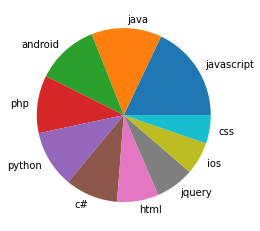

In [114]:
plt.pie(topten_trends.values,labels = topten_trends.index)
plt.show()

#Final Results : 

---



## Display Results

In [117]:
so_users_and_responses = Final_Results

In [119]:
so_users_and_responses

Top 5 Users who can answer  ...  75%-Response-time (mins)
python       100297,190597,20862,104349,771848  ...                     144.0
r          1144035,100297,3732271,13302,771848  ...                     227.0
matlab    2586922,97160,232610,3250829,2732801  ...                     191.0
sas     1623007,1919583,214994,2734437,1652962  ...                     924.0
excel   2474656,1505120,4039065,1140579,478884  ...                     185.0
sql          1144035,491243,13302,939860,27535  ...                      63.0

[6 rows x 3 columns]

In [208]:
so_rules.reset_index(drop = True)

antecedents  ...                              antecedents-list
0                     (tsql, sql)  ...                    frozenset({'tsql', 'sql'})
1                    (python-3.x)  ...                     frozenset({'python-3.x'})
2                     (excel-vba)  ...                      frozenset({'excel-vba'})
3                    (python-2.7)  ...                     frozenset({'python-2.7'})
4                          (tsql)  ...                           frozenset({'tsql'})
5   (sql-server, sql-server-2008)  ...  frozenset({'sql-server', 'sql-server-2008'})
6              (sql-server, tsql)  ...             frozenset({'sql-server', 'tsql'})
7          (sql, sql-server-2008)  ...         frozenset({'sql', 'sql-server-2008'})
8                          (tsql)  ...                           frozenset({'tsql'})
9               (sql-server-2008)  ...                frozenset({'sql-server-2008'})
10                   (sql-server)  ...                     frozenset({'sql-server'})
11              (sql-server-2008)  ...                frozenset({'sql-server-2008'})
12                         (tsql)  ...                           frozenset({'tsql'})
13                        (excel)  ...                          frozenset({'excel'})
14                   (postgresql)  ...                     frozenset({'postgresql'})
15              (sql-server-2008)  ...                frozenset({'sql-server-2008'})
16                          (sql)  ...                            frozenset({'sql'})
17                          (sql)  ...                            frozenset({'sql'})
18                        (mysql)  ...                          frozenset({'mysql'})
19              (sql-server, sql)  ...              frozenset({'sql-server', 'sql'})
20              (sql-server, sql)  ...              frozenset({'sql-server', 'sql'})
21                   (sql-server)  ...                     frozenset({'sql-server'})
22                   (sql-server)  ...                     frozenset({'sql-server'})
23                   (sql-server)  ...                     frozenset({'sql-server'})
24                   (sql-server)  ...                     frozenset({'sql-server'})
25                          (sql)  ...                            frozenset({'sql'})
26                          (sql)  ...                            frozenset({'sql'})
27                       (python)  ...                         frozenset({'python'})
28                       (python)  ...                         frozenset({'python'})
29                          (sql)  ...                            frozenset({'sql'})
30                          (sql)  ...                            frozenset({'sql'})
31                          (sql)  ...                            frozenset({'sql'})

[32 rows x 10 columns]

In [166]:
so_rules.head(3)

antecedents   consequents  ...  conviction            antecedents-list
28   (tsql, sql)  (sql-server)  ...    2.903643  frozenset({'tsql', 'sql'})
8   (python-3.x)      (python)  ...    2.064585   frozenset({'python-3.x'})
1    (excel-vba)       (excel)  ...    2.809298    frozenset({'excel-vba'})

[3 rows x 10 columns]

In [217]:
so_rules = (so_rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))

In [218]:
antecedentslst=[]
for item in so_rules.antecedents:
  antecedentslst.append(list(item))

In [219]:
consequentslst=[]
for item in so_rules.consequents:
  consequentslst.append(list(item))

In [220]:
so_rules['antecedents'] = antecedentslst 
so_rules['consequents'] = consequentslst

In [221]:
so_rules.head(5)

antecedents   consequents  ...  leverage  conviction
0   [tsql, sql]  [sql-server]  ...  0.006968    2.903643
1  [python-3.x]      [python]  ...  0.007628    2.064585
2   [excel-vba]       [excel]  ...  0.016958    2.809298
3  [python-2.7]      [python]  ...  0.009297    1.853349
4        [tsql]  [sql-server]  ...  0.011931    2.457985

[5 rows x 9 columns]

# Store to RDS Database

## First DB 
to store Top 5 users to notify and provide a approxmate time range ( Between 50% to 75% percentile)

In [127]:
host1='test-instance1.cpuhpqgnujqo.us-east-1.rds.amazonaws.com'
port1=int(3306)
user='master'
passw='soassignment'
database1='top_5_id_and_response_time'

mydb1 = create_engine('mysql+pymysql://' + user + ':' + passw + '@' + host1 + ':' + str(port1) + '/' + database1 , echo=False)

## Seconds DB
to Store the Rules of predictive Tags , More tags can give faster response with wider audience

In [222]:
host2='test-instance-2.cpuhpqgnujqo.us-east-1.rds.amazonaws.com'
port2=int(3306)
user='master'
passw='soassignment'
database2='so_rules_predictive_tag'

mydb2 = create_engine('mysql+pymysql://' + user + ':' + passw + '@' + host2 + ':' + str(port2) + '/' + database2 , echo=False)

In [123]:
test.to_sql(name="top_5_id_and_response_time", con=mydb1, if_exists='replace', index=False) 


In [223]:
test_df.to_sql(name="so_rules_predictive_tag", con=mydb2, if_exists='replace', index=False) 

---



#         Complete

---

